# Exercise 1: Orchestrating Data for Delivery Intelligence

This is the first part in a series of exercises where you'll build a Delivery Route Intelligence Agent—designed to help general office associates (GOAs) reduce avoidable delivery failures.

In this exercise, you'll learn how to:
- Query BigQuery tables using ADK agents
- Orchestrate multiple agents working together
- Pass data between agents using `output_key`
- Build a pipeline that works with a specific order number

By the end, you'll have a working data collection pipeline that fetches comprehensive delivery information for any order in the dataset.

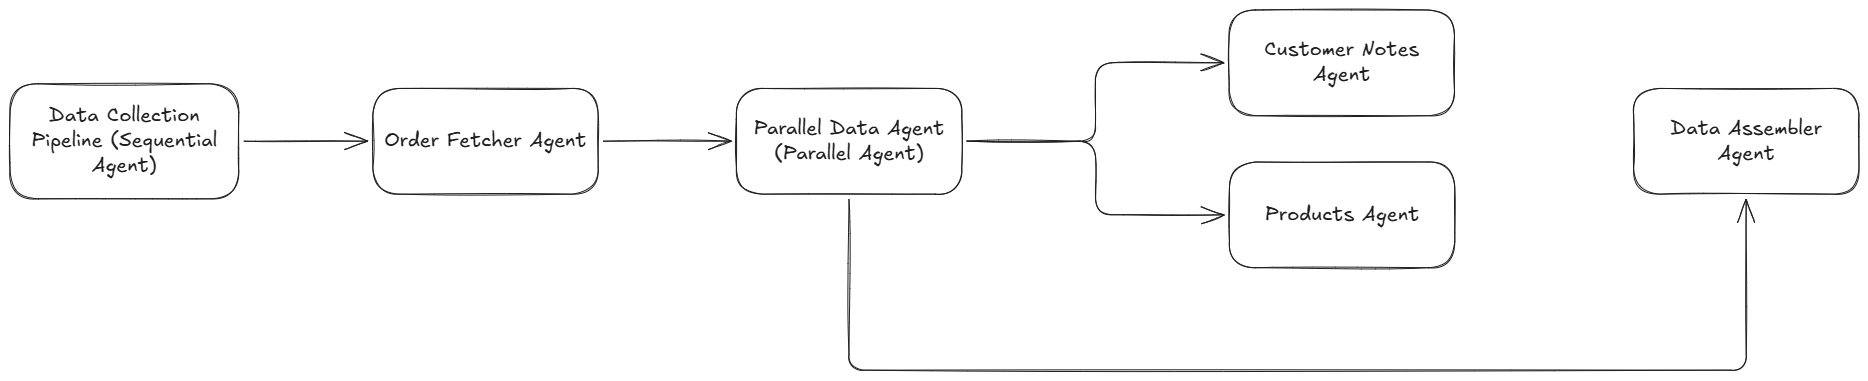

## 🎯 Order Selection

Choose which order to analyze by setting the ORDER_NUMBER below. This order will be used throughout all exercises.

In [ ]:
# SELECT YOUR ORDER NUMBER HERE
ORDER_NUMBER = "CG92094171"  # Change this to analyze a different order

print(f"📦 Order selected: {ORDER_NUMBER}")
print("This order will be used throughout the workshop exercises.")

### Environment Setup

In [ ]:
import os
import warnings
import logging

# Suppress ALL warnings for clean output
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
logging.getLogger().setLevel(logging.ERROR)

# Configure Google Cloud environment
os.environ["GOOGLE_GENAI_USE_VERTEXAI"] = "True"
os.environ["GOOGLE_CLOUD_PROJECT"] = "traversaal-research"
os.environ["GOOGLE_CLOUD_LOCATION"] = "us-central1"

# BigQuery configuration
DATASET_ID = "delivery_intelligence"
PROJECT_ID = "traversaal-research"

print(f"✅ Environment configured")
print(f"📊 Using BigQuery dataset: {PROJECT_ID}.{DATASET_ID}")

## The Challenge: Built-in Tools and Sub-agents

In ADK, you might think to use the built-in BigQuery toolset for database queries. It handles authentication, query execution, and results formatting automatically.

However, there's an important limitation in the ADK documentation:

> **"Built-in tools cannot be used within a sub-agent"**

Since we need to orchestrate multiple agents working together (some in parallel), we can't use the built-in BigQuery toolset. Instead, we'll create a custom function tool that our agents can use.

This actually gives us more control and makes the code simpler to understand—perfect for learning!

In [ ]:
from google.cloud import bigquery
import google.auth
from google.adk.agents import Agent, ParallelAgent, SequentialAgent
from google.adk.sessions import InMemorySessionService
from google.adk.runners import Runner
from google.genai import types

# Initialize BigQuery client with proper authentication
credentials, project = google.auth.default()
bq_client = bigquery.Client(credentials=credentials, project=project)

## Creating Our BigQuery Query Tool

First, we'll create a custom function tool that all our agents can use to query BigQuery:

In [ ]:
# Generic BigQuery function tool that all agents will use
def execute_query(query: str) -> dict:
    """Execute a BigQuery SQL query and return results
    
    Args:
        query: The SQL query to execute
        
    Returns:
        A dictionary with status and data/error
    """
    try:
        # Execute the query
        result = bq_client.query(query).result()
        
        # Convert rows to list of dictionaries
        rows = []
        for row in result:
            rows.append(dict(row))
            
        return {"status": "success", "data": rows}
    except Exception as e:
        return {"status": "error", "error": str(e)}

print("✅ BigQuery query tool created")

In [ ]:
# Set our model for all agents
GEMINI_MODEL = "gemini-2.0-flash"

print(f"✅ Using model: {GEMINI_MODEL}")

## Creating the Data Collection Agents

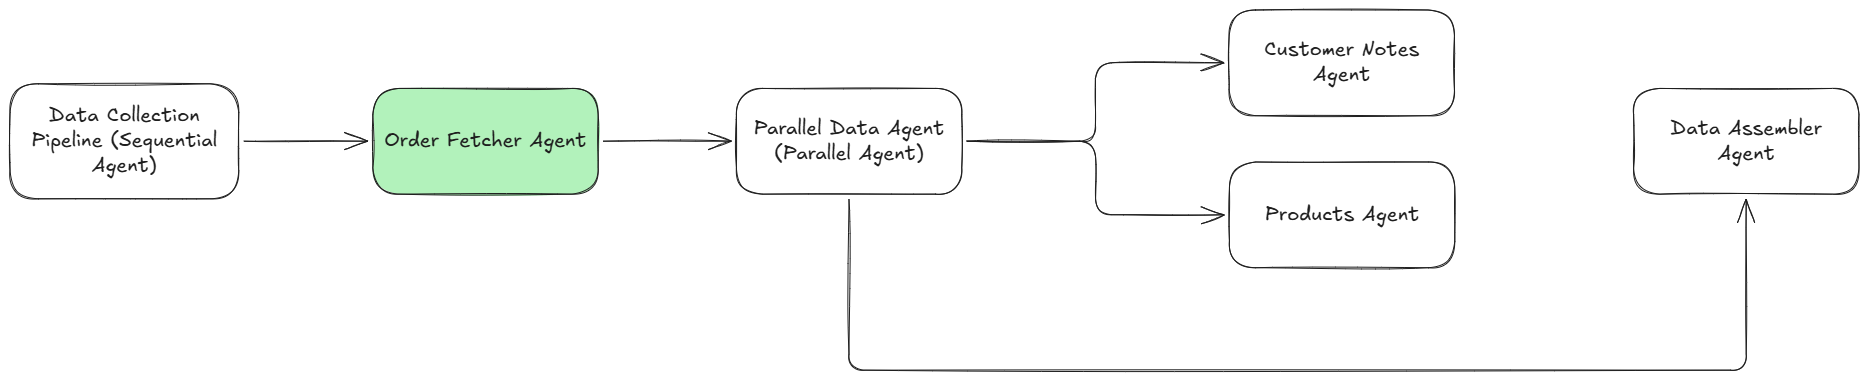

Now let's create our agents. First, the order fetcher agent that gets the main delivery data:

In [ ]:
# First agent - gets order data for a specific order number
order_fetcher_agent = Agent(
    model=GEMINI_MODEL,
    name="order_fetcher_agent",
    description="Fetches order data for a specific order number",
    instruction=f"""\
        You will receive an order number in the user message.
        Use the execute_query tool to run this SQL query:
        
        ```sql
        SELECT *
        FROM `{PROJECT_ID}.{DATASET_ID}.delivery_orders`
        WHERE CUSTOMER_ORDER_NUMBER = '<ORDER_NUMBER>'
        ```
        
        Replace <ORDER_NUMBER> with the actual order number provided.
        Return the order data found.
        """,
    tools=[execute_query],
    output_key="order_data"
)

## Additional Data Agents

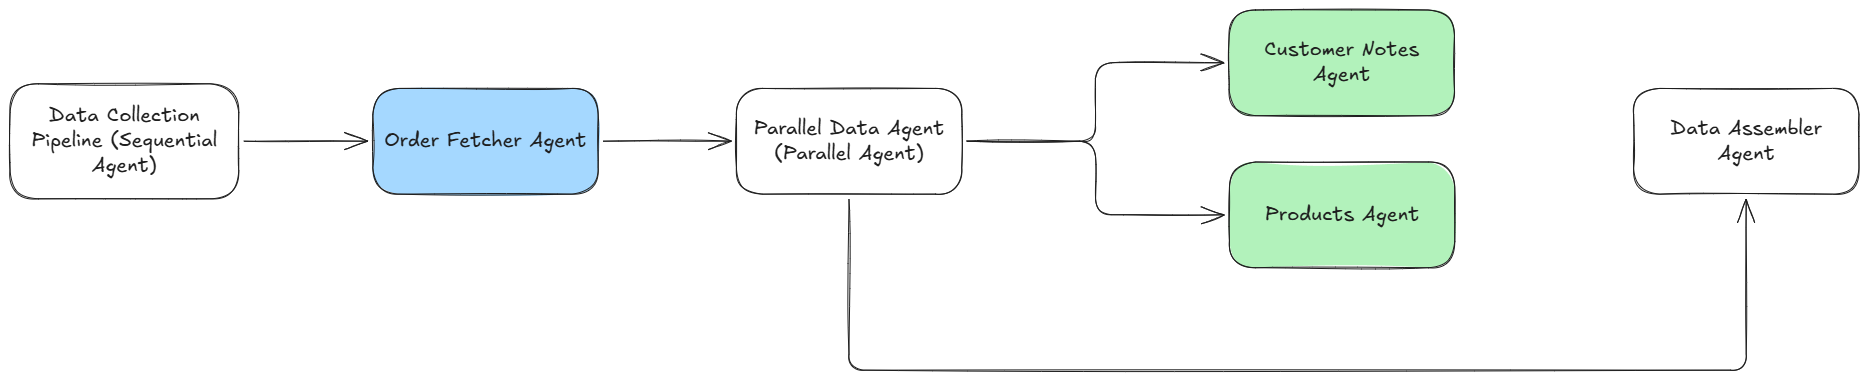

Next, we create agents to fetch related data (customer notes and products). These will run in parallel for efficiency:

In [ ]:
# Customer notes agent - gets special instructions
customer_notes_agent = Agent(
    model=GEMINI_MODEL,
    name="customer_notes_agent", 
    description="Fetches customer notes and summaries",
    instruction=f"""\
You will receive order information in {{order_data}}.
Extract the DATA_ID value from that data.

Use the execute_query tool to run this SQL query:

```sql
SELECT *
FROM `{PROJECT_ID}.{DATASET_ID}.delivery_notes`
WHERE DATA_ID = <DATA_ID>
```

Replace <DATA_ID> with the actual DATA_ID value.
Return the notes data found.
""",
    tools=[execute_query],
    output_key="notes_data"
)

# Products agent - gets SKU information
products_agent = Agent(
    model=GEMINI_MODEL,
    name="products_agent",
    description="Fetches product information for the order",
    instruction=f"""\
You will receive order information in {{order_data}}.
Extract the DATA_ID value from that data.

Use the execute_query tool to run this SQL query:

```sql
SELECT *
FROM `{PROJECT_ID}.{DATASET_ID}.delivery_products`
WHERE DATA_ID = <DATA_ID>
```

Replace <DATA_ID> with the actual DATA_ID value.
Return all products associated with this order.
""",
    tools=[execute_query],
    output_key="products_data"
)

print("✅ Data fetching agents created")
print("\nThese agents will:")
print("1. Fetch delivery notes (special instructions)")
print("2. Get all products/SKUs for the order")

## Orchestrating with Workflow Agents

Now comes the magic of ADK's workflow agents. We'll use a `ParallelAgent` to run both customer and product queries at the same time.

**ParallelAgent** benefits:
- Faster execution (both queries run simultaneously)
- Better resource utilization
- Simpler error handling (if one fails, you know immediately)

The parallel agent doesn't do any work itself—it just coordinates the execution of its sub-agents.

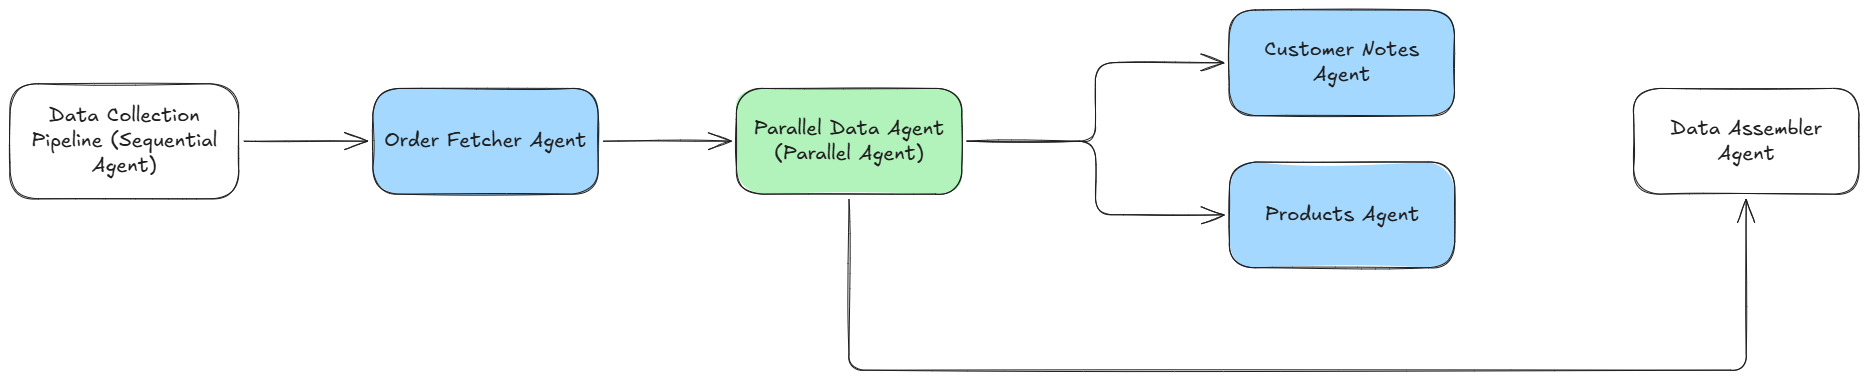

In [ ]:
# Parallel agent for notes and products (after we have the order)
parallel_data_agent = ParallelAgent(
    name="parallel_data_agent",
    sub_agents=[customer_notes_agent, products_agent],
    description="Fetch customer notes and products in parallel",
)

## Data Assembly Agent

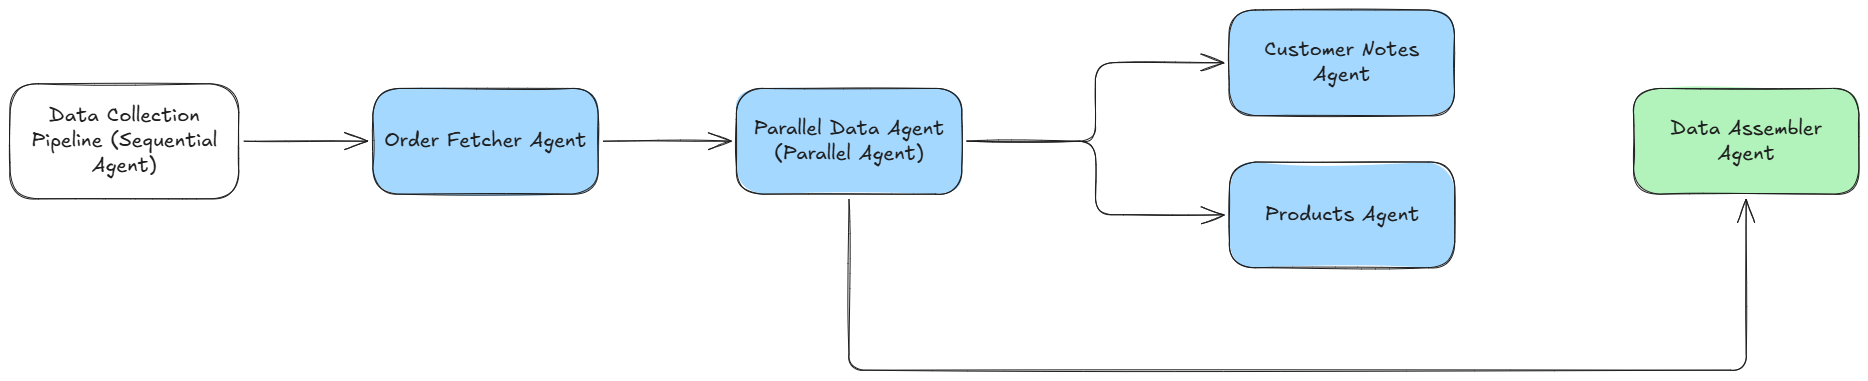

The final agent assembles all the collected data into a structured format:

In [ ]:
# Final agent that assembles the structured data
data_assembler_agent = Agent(
    name="data_assembler_agent",
    model=GEMINI_MODEL,
    description="Assembles all collected data into structured format",
    instruction="""\
You have data from the previous agents:
Order Data: {{order_data}}
Notes Data: {{notes_data}}  
Products Data: {{products_data}}

Create a structured JSON output combining all data in this format:
{{
    "order": {{
        "DATA_ID": <from order data>,
        "CUSTOMER_ORDER_NUMBER": <from order data>,
        "WORK_ORDER_NUMBER": <from order data>,
        "SCHEDULED_DELIVERY_DATE": <from order data>,
        "VEHICLE_TYPE": <from order data>,
        "QUANTITY": <from order data>,
        "VOLUME_CUBEFT": <from order data>,
        "WEIGHT": <from order data>,
        "PALLET": <from order data>,
        "SERVICE_TYPE": <from order data>,
        "WINDOW_START": <from order data>,
        "WINDOW_END": <from order data>
    }},
    "customer": {{
        "CUSTOMER_NAME": <from order data>,
        "PRO_XTRA_MEMBER": <from order data>,
        "MANAGED_ACCOUNT": <from order data>,
        "COMMERCIAL_ADDRESS_FLAG": <from order data>,
        "DESTINATION_ADDRESS": <from order data>,
        "BUSINESS_HOURS": <from order data>,
        "CUSTOMER_NOTES": <from notes data>,
        "CUSTOMER_NOTES_LLM_SUMMARY": <from notes data>
    }},
    "products": [<list of SKU_DESCRIPTION from products data>],
    "environmental": {{
        "WTHR_CATEGORY": <from order data>,
        "PRECIPITATION": <from order data>,
        "STRT_VW_IMG_DSCRPTN": <from order data>
    }},
    "risk_info": {{
        "DLVRY_RISK_DECILE": <from order data>,
        "DLVRY_RISK_BUCKET": <from order data>,
        "DLVRY_RISK_PERCENTILE": <from order data>,
        "DLVRY_RISK_TOP_FEATURE": <from order data>
    }}
}}

Return ONLY the JSON structure, no additional text.
""",
    tools=[],
    output_key="structured_data"
)

print("✅ Data assembler agent created")

## Building the Complete Pipeline

Now we bring it all together with a `SequentialAgent` that orchestrates our entire flow:

1. **order_fetcher_agent** → Gets data for our specific order
2. **parallel_data_agent** → Runs notes & products agents in parallel
3. **data_assembler_agent** → Combines everything into structured JSON

This creates a reusable pipeline that can fetch data for any order!

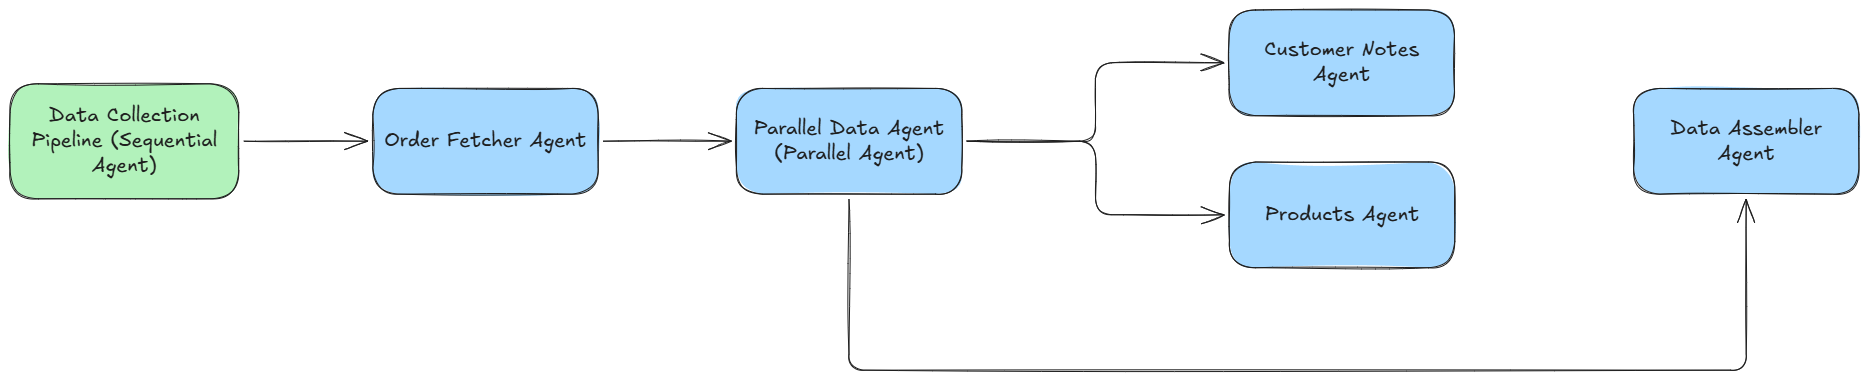

In [ ]:
# Full data collection pipeline
data_collection_pipeline = SequentialAgent(
    name="data_collection_pipeline",
    sub_agents=[order_fetcher_agent, parallel_data_agent, data_assembler_agent],
    description="Complete data collection pipeline",
)

## Setting Up the ADK Runtime

Before we can run our agents, we need to set up the ADK runtime components:

1. **Session Service**: Manages conversation state and agent outputs
2. **Runner**: Executes the agent pipeline and handles the event stream

Let's configure these components:

In [ ]:
# Setup configuration
APP_NAME = "data_collection"
USER_ID = "user_1"
SESSION_ID = "data_session_001"

# Create session service
session_service = InMemorySessionService()

## Running the Pipeline

Now for the exciting part! Let's run our complete data collection pipeline.

We'll create an async function that:
1. Creates a session
2. Sets up the runner
3. Sends a message to start the pipeline
4. Processes the event stream, showing progress
5. Displays only the final formatted output

Notice how we suppress warnings to keep the output clean for learners:

In [ ]:
import sys
import io
import json

async def collect_data(order_number: str):
    """Collect data for a specific order"""
    # Create session
    await session_service.create_session(
        app_name=APP_NAME, user_id=USER_ID, session_id=SESSION_ID
    )

    # Create runner
    runner = Runner(
        agent=data_collection_pipeline,
        app_name=APP_NAME,
        session_service=session_service,
    )

    print("=" * 60)
    print("DATA COLLECTION PIPELINE")
    print("=" * 60)
    print(f"\nCollecting data for order: {order_number}")
    print("\nRunning data collection pipeline...\n")

    # Create the user message with the order number
    content = types.Content(
        role="user",
        parts=[types.Part(text=order_number)],
    )

    # Temporarily redirect stderr to suppress runtime warnings
    old_stderr = sys.stderr
    sys.stderr = io.StringIO()
    
    try:
        async for event in runner.run_async(
            user_id=USER_ID, session_id=SESSION_ID, new_message=content
        ):
            # Restore stderr briefly for our print statements
            sys.stderr = old_stderr
            
            # Show progress
            if hasattr(event, "author") and event.author:
                if event.author in [
                    "order_fetcher_agent",
                    "customer_notes_agent", 
                    "products_agent",
                    "data_assembler_agent"
                ]:
                    print(f"[{event.author}] processing...")

            # Capture final structured output
            if event.is_final_response() and event.author == "data_assembler_agent":
                if event.content and event.content.parts:
                    print("\n" + "=" * 60)
                    print("DATA COLLECTION COMPLETE")
                    print("=" * 60)
                    
                    # Parse and save JSON
                    try:
                        data_text = event.content.parts[0].text.strip()
                        # Remove markdown if present
                        if data_text.startswith("```json"):
                            data_text = data_text[7:]
                        if data_text.endswith("```"):
                            data_text = data_text[:-3]
                        
                        json_data = json.loads(data_text.strip())
                        
                        # Save to file
                        with open('collected_order_data.json', 'w') as f:
                            json.dump(json_data, f, indent=2)
                        
                        # Display summary
                        print(f"\nOrder: {json_data['order']['CUSTOMER_ORDER_NUMBER']}")
                        print(f"Customer: {json_data['customer']['CUSTOMER_NAME']}")
                        print(f"Delivery Date: {json_data['order']['SCHEDULED_DELIVERY_DATE']}")
                        print(f"Products: {len(json_data['products'])} items")
                        print(f"Risk Level: {json_data['risk_info']['DLVRY_RISK_BUCKET']}")
                        
                        print("\n✅ Data saved to collected_order_data.json")
                        print("\nThis file will be used by subsequent exercises.")
                    except Exception as e:
                        print(f"Error parsing JSON: {e}")
                        print(event.content.parts[0].text)
                break
                
            # Suppress warnings again
            sys.stderr = io.StringIO()
    finally:
        # Always restore stderr
        sys.stderr = old_stderr

# Run the pipeline with our selected order
await collect_data(ORDER_NUMBER)

## What Just Happened?

Let's break down the execution flow:

1. **order_fetcher_agent** ran first and fetched all data for order `{ORDER_NUMBER}` from BigQuery
2. Its output was saved as `order_data`
3. **parallel_data_agent** orchestrated two parallel queries:
   - **customer_notes_agent** extracted DATA_ID and fetched notes
   - **products_agent** extracted DATA_ID and fetched all products
4. Both outputs were saved as `notes_data` and `products_data`
5. **data_assembler_agent** combined all three outputs into structured JSON

### Key Improvements

- **Real Data**: We're now using actual delivery data from BigQuery
- **Order-Specific**: The pipeline works with any order number
- **Structured Output**: Data is saved as `collected_order_data.json` for use in subsequent exercises
- **Reusable**: This same order will flow through all workshop exercises

This demonstrates the power of ADK's agent orchestration for building data pipelines that work with production data!

## Try It Yourself!

Now it's your turn to experiment with the code. Here are some exercises to deepen your understanding:

### Exercise 1: Get Multiple Orders
Modify the `order_selector_agent` to fetch the 5 most recent orders instead of just 1. How would you need to change the downstream agents?

### Exercise 2: Add a New Data Source
Create a new agent that fetches delivery status information. Add it to the parallel execution group. You'll need to:
- Create the agent with appropriate SQL
- Add it to the `related_data_agent` sub_agents list
- Update the display agent to show the new data

### Exercise 3: Custom Formatting
Modify the display agent to output data in a different format (e.g., JSON, CSV-style, or a more detailed report).

### Challenge: Error Handling
What happens if a customer ID doesn't exist? Add error handling to make the pipeline more robust.

## Troubleshooting & Key Concepts

### Common Issues and Solutions

1. **"Built-in tools cannot be used within a sub-agent"**
   - This is why we created custom function tools
   - Always use custom tools when building multi-agent workflows

2. **Token Limit Errors**
   - Keep queries focused and limit result sizes
   - Use `LIMIT` clauses in SQL queries
   - Consider pagination for large datasets

3. **Agent Communication**
   - Always specify `output_key` for agents whose data you need later
   - Use `{output_key_name}` in instructions to reference previous outputs
   - Check agent names match when filtering events

4. **Warning Messages**
   - We suppress warnings for cleaner educational output
   - In production, you might want to see these for debugging

### Key Takeaways

- **Custom tools** provide flexibility when built-in tools have limitations
- **Sequential and Parallel agents** let you orchestrate complex workflows
- **output_key** enables data passing between agents
- **Event processing** lets you control what users see
- **Generic functions** reduce code duplication and improve maintainability

Congratulations! You've built a sophisticated data orchestration pipeline using Google ADK. This foundation will serve you well as you build more complex agent systems.